# Predicting Delayed Flights in the U.S.

- This workbook will explore the "[`Flights Dataset`](http://stat-computing.org/dataexpo/2009/the-data.html)" and predicts delayed flights at airports located in the United States bases on previous flight records. The dataset consists of flight information such as arrival and departure times. Additionally, the .dat file for plotting the geographical location of airports in the U.S. can be found [`here`](https://github.com/jpatokal/openflights/blob/master/data/airports.dat). Jupyter Notebook and Spark is utilized to explore, analyze and visualize the results. This dataset examines flights in 2008 which is roughly 7 million flights! Apache Spark (locally) will be utilized to analyze this dataset. 

In [5]:
%matplotlib inline

In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row

In [7]:
from IPython.display import display
from IPython.html.widgets import interact
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as pl
import os.path
%matplotlib inline

## PostgreSQL

In [9]:
import psycopg2
import sys


In [10]:
from sqlalchemy import create_engine
db = create_engine('postgres://localhost:5432/flights')

In [13]:
# connect locally to database
%load_ext sql
%sql postgres://localhost:5432/flights

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


u'Connected: None@flights'

In [20]:
# Create a table to import flight data from .csv file
%sql CREATE TABLE IF NOT EXISTS flight_info(Year INT,\
Month INT,\
DayofMonth INT,\
DayOfWeek INT,\
DepTime INT,\
CRSDepTime INT,\
ArrTime INT,\
CRSArrTime INT,\
UniqueCarrier TEXT,\
FlightNum INT,\
TailNum CHAR(8),\
ActualElapsedTime INT,\
CRSElapsedTime INT,\
AirTime INT,\
ArrDelay INT,\
DepDelay INT,\
Origin TEXT,\
Dest TEXT,\
Distance INT,\
TaxiIn INT,\
TaxiOut INT,\
Cancelled INT,\
CancellationCode TEXT,\
Diverted INT,\
CarrierDelay INT,\
WeatherDelay INT,\
NASDelay INT,\
SecurityDelay INT,\
LateAircraftDelay INT);

Done.


[]

In [21]:
#import .csv file to flight_info table
%sql COPY flight_info FROM '/Users/tracesmith/Desktop/spark/flights/data/2008.csv' WITH (FORMAT CSV, NULL 'NA', HEADER)

7009728 rows affected.


[]

In [22]:
%sql ALTER TABLE flight_info ADD COLUMN id SERIAL;
%sql UPDATE TABLE SET id = default; 
%sql TABLE flight_info ADD PRIMARY KEY (id);

Done.
(psycopg2.ProgrammingError) syntax error at or near "TABLE"
LINE 1: UPDATE TABLE SET id = default;
               ^
 [SQL: 'UPDATE TABLE SET id = default;']
(psycopg2.ProgrammingError) syntax error at or near "ADD"
LINE 1: TABLE flight_info ADD PRIMARY KEY (id);
                          ^
 [SQL: 'TABLE flight_info ADD PRIMARY KEY (id);']


In [25]:
database_df = pd.read_sql_query('SELECT * FROM flight_info LIMIT 2', db)

In [26]:
database_df

,year,month,dayofmonth,dayofweek,deptime,crsdeptime,arrtime,crsarrtime,uniquecarrier,flightnum,...,taxiout,cancelled,cancellationcode,diverted,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,id
0,2008,1,3,4,2003,1955,2211,2225,WN,335,...,8,0,,0,None,None,None,None,None,1
1,2008,1,3,4,754,735,1002,1000,WN,3231,...,10,0,,0,None,None,None,None,None,2


In [96]:
# Create Table with Aiport Locations
%sql CREATE TABLE IF NOT EXISTS airports(AirportID INT,\
Name TEXT,\
City TEXT,\
Country TEXT,\
FAA_CODE TEXT,\
ICAO TEXT,\
LAT REAL,\
LONG REAL,\
ALT INT,\
TimeZone REAL,\
DST TEXT,\
TZ TEXT)                                         

Done.


[]

In [149]:
#Created Table in DF of airports
%sql COPY airports FROM '/Users/tracesmith/Desktop/spark/flights/data/airport_location.csv' WITH (FORMAT CSV, NULL 'NA')
airport = pd.read_sql_query('SELECT * FROM airports LIMIT 5',db)

8107 rows affected.


In [157]:
airport_loc_df = pd.read_csv('/Users/tracesmith/Desktop/spark/flights/data/airport_location.csv',index_col=0,
        names = ['name', 'city', 'country','faa_code','ICAO','lat',
        'lng','alt','TZone','DST','Tz'], header=0)
airport_loc_df.head()

,name,city,country,faa_code,ICAO,lat,lng,alt,TZone,DST,Tz
2,Madang,Madang,Papua New Guinea,MAG,AYMD,-5.207083,145.788700,20,10.0,U,Pacific/Port_Moresby
3,Mount Hagen,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789,144.295861,5388,10.0,U,Pacific/Port_Moresby
4,Nadzab,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569828,146.726242,239,10.0,U,Pacific/Port_Moresby
5,Port Moresby Jacksons Intl,Port Moresby,Papua New Guinea,POM,AYPY,-9.443383,147.220050,146,10.0,U,Pacific/Port_Moresby
6,Wewak Intl,Wewak,Papua New Guinea,WWK,AYWK,-3.583828,143.669186,19,10.0,U,Pacific/Port_Moresby


## Apache Spark

In [108]:
data = sc.textFile("./data/2008.csv")

In [59]:
count_data = data.count()
print "Total Number of Rows: %s" % count_data

Total Number of Rows: 7009729


#### Preprocessing Data: 

In [110]:
split_dataRDD = data.map(lambda line: line.split(','))
header = split_dataRDD.first()
print header
textRDD = split_dataRDD.filter(lambda r: r != header)

[u'Year', u'Month', u'DayofMonth', u'DayOfWeek', u'DepTime', u'CRSDepTime', u'ArrTime', u'CRSArrTime', u'UniqueCarrier', u'FlightNum', u'TailNum', u'ActualElapsedTime', u'CRSElapsedTime', u'AirTime', u'ArrDelay', u'DepDelay', u'Origin', u'Dest', u'Distance', u'TaxiIn', u'TaxiOut', u'Cancelled', u'CancellationCode', u'Diverted', u'CarrierDelay', u'WeatherDelay', u'NASDelay', u'SecurityDelay', u'LateAircraftDelay']


#### Create DataFrame

In [111]:
def parse(r):
    try:
        x = Row(Year=int(r[0]),\
            Month=int(r[1]),\
            DayofMonth=int(r[2]),\
            DayOfWeek=int(r[3]),\
            DepTime=int(float(r[4])), \
            CRSDepTime=int(r[5]),\
            ArrTime=int(float(r[6])),\
            CRSArrTime=int(r[7]), \
            UniqueCarrier=r[8],\
            DepDelay=int(float(r[15])),\
            Origin=r[16],\
            Dest=r[17], \
            Distance=int(float(r[18])))  
    except:
        x=None  
    return x

In [112]:
rowRDD = textRDD.map(lambda r: parse(r)).filter(lambda r:r != None)
dataframe = sqlContext.createDataFrame(rowRDD)

In [113]:
dataframe.show(5)

+-------+----------+----------+---------+----------+--------+-------+----+--------+-----+------+-------------+----+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Month|Origin|UniqueCarrier|Year|
+-------+----------+----------+---------+----------+--------+-------+----+--------+-----+------+-------------+----+
|   2211|      2225|      1955|        4|         3|       8|   2003| TPA|     810|    1|   IAD|           WN|2008|
|   1002|      1000|       735|        4|         3|      19|    754| TPA|     810|    1|   IAD|           WN|2008|
|    804|       750|       620|        4|         3|       8|    628| BWI|     515|    1|   IND|           WN|2008|
|   1054|      1100|       930|        4|         3|      -4|    926| BWI|     515|    1|   IND|           WN|2008|
|   1959|      1925|      1755|        4|         3|      34|   1829| BWI|     515|    1|   IND|           WN|2008|
+-------+----------+----------+---------+----------+--------+-------+---

- Adding binary labels to **DepDelayed** columns as this will become the "target" column for the predicitons. 
    - **True** for flights that have more than 15 minute delay (t>15)
    - **False** for flights that are less than or equal to 15 minute delay (<=15)

In [114]:
#Adding column 'DepDelayed' and assigning True/False if >15 mins
dataframe = dataframe.withColumn('DepDelayed', dataframe['DepDelay']>15)

In [115]:
dataframe.show(5)

+-------+----------+----------+---------+----------+--------+-------+----+--------+-----+------+-------------+----+----------+
|ArrTime|CRSArrTime|CRSDepTime|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Month|Origin|UniqueCarrier|Year|DepDelayed|
+-------+----------+----------+---------+----------+--------+-------+----+--------+-----+------+-------------+----+----------+
|   2211|      2225|      1955|        4|         3|       8|   2003| TPA|     810|    1|   IAD|           WN|2008|     false|
|   1002|      1000|       735|        4|         3|      19|    754| TPA|     810|    1|   IAD|           WN|2008|      true|
|    804|       750|       620|        4|         3|       8|    628| BWI|     515|    1|   IND|           WN|2008|     false|
|   1054|      1100|       930|        4|         3|      -4|    926| BWI|     515|    1|   IND|           WN|2008|     false|
|   1959|      1925|      1755|        4|         3|      34|   1829| BWI|     515|    1|   IND|           WN|2

- In the following script, a new column **Hour** is added to determine what is the hour of flight (0 to 24)

In [116]:
def hour(x):
    hour = int(str(int(x)).zfill(4)[:2])
    return hour

In [117]:
# register as a UDF 
f = udf(hour, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
dataframe = dataframe.withColumn('hour', f(dataframe.CRSDepTime))
dataframe.registerTempTable("dataframe")

In [118]:
dataframe.select('CRSDepTime','hour').show(5)

+----------+----+
|CRSDepTime|hour|
+----------+----+
|      1955|  19|
|       735|   7|
|       620|   6|
|       930|   9|
|      1755|  17|
+----------+----+
only showing top 5 rows



### Exploring the Data:

In [304]:
# Which airport has the most delays??
# Write SQL query to group delays 

delays = sqlContext.sql("SELECT Origin, count(*) Num_Flights,avg(DepDelay) Delay FROM dataframe GROUP BY Origin")

origin_df = delays.toPandas() #convert to dataframe
origin_df.head()

,Origin,Num_Flights,Delay
0,IAH,181496,10.558222
1,RFD,285,2.312281
2,GEG,15349,5.911395
3,YUM,3779,2.881715
4,TUS,26410,5.276524


In [303]:
#Join origin_df with airports
df_airports = pd.merge(origin_df,airport_loc_df,left_on = 'Origin',right_on = 'faa_code')
df_airports.head()

,Origin,Num_Flights,Delay,name,city,country,faa_code,ICAO,lat,lng,alt,TZone,DST,Tz
0,IAH,181496,10.558222,George Bush Intercontinental,Houston,United States,IAH,KIAH,29.984433,-95.341442,97,-6.0,A,America/Chicago
1,RFD,285,2.312281,Chicago Rockford International Airport,Rockford,United States,RFD,KRFD,42.195361,-89.097222,742,-6.0,A,America/Chicago
2,GEG,15349,5.911395,Spokane Intl,Spokane,United States,GEG,KGEG,47.619861,-117.533833,2376,-8.0,A,America/Los_Angeles
3,YUM,3779,2.881715,Yuma Mcas Yuma Intl,Yuma,United States,YUM,KYUM,32.656578,-114.605980,216,-7.0,N,America/Phoenix
4,TUS,26410,5.276524,Tucson Intl,Tucson,United States,TUS,KTUS,32.116083,-110.941028,2643,-7.0,N,America/Phoenix


/Users/tracesmith/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


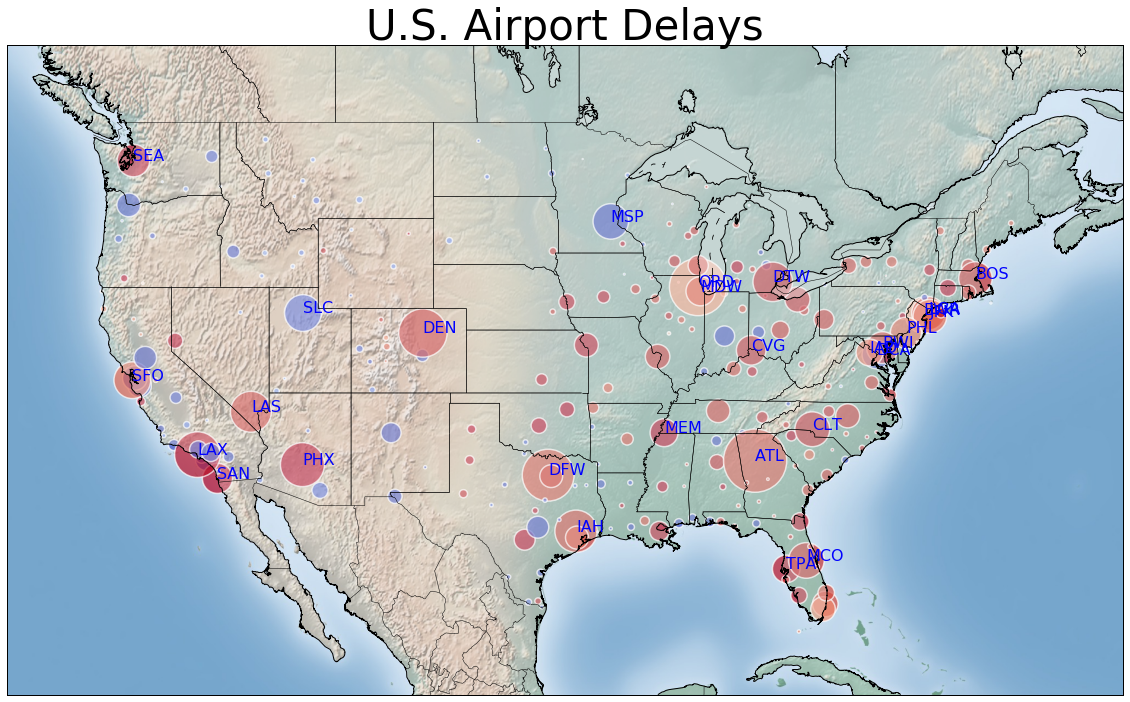

In [302]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as pl
from pylab import rcParams
%matplotlib inline

def zscore(x):
    return (x-np.average(x))/np.std(x)

fig = pl.figure(figsize=(20,20))
map = Basemap(projection = 'merc',area_thresh = 4000,resolution ='i',
              rsphere=6371200.,llcrnrlon=-130, 
              llcrnrlat=21,urcrnrlon=-62, urcrnrlat=52)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'white',alpha=0.3)
map.drawstates()
map.shadedrelief()

#Plot Airport Delay
countrange=max(df_airports['Num_Flights'])-min(df_airports['Num_Flights'])
standarize = (zscore(df_airports['Delay']))
x,y = map(np.asarray(df_airports['lng']),np.asarray(df_airports['lat']))
volume=df_airports['Num_Flights']*4000.0/countrange

#Add color to map:
color = pl.get_cmap('coolwarm')(np.linspace(0.0,1.0,70))
color = np.flipud(color)
map.scatter(x, y,  marker='o', s= volume, linewidths=1.5,
    edgecolors='white', alpha = .7, color=color[(standarize*10)])

#Add Labels to Map
df_text=df_airports[(df_airports['Num_Flights']>70000) \
                    & (df_airports['faa_code'] != 'HNL')] #ignoring Hawaii
xtext,ytext = map(np.asarray(df_text['lng']), np.asarray(df_text['lat']))
txt=np.asarray(df_text['faa_code'])
zp=zip(xtext,ytext,txt)
for row in zp:
    pl.text(row[0],row[1],row[2], fontsize=16, color='blue',)

pl.title("U.S. Airport Delays", fontsize = 42)    
pl.show()